In [4]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121, MobileNetV2
from tensorflow.keras.layers import Input, Concatenate, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# Define parameters
img_height, img_width = 224, 224
batch_size = 128
num_classes = 6  # Assuming PlantVillage has 38 classes



In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Load and preprocess the PlantVillage dataset
data_dir = '/content/drive/MyDrive/Tomato_leaf_diseases'



In [8]:
# Get list of image file paths and corresponding labels
image_paths = []
labels = []
class_names = sorted(os.listdir(data_dir))
class_indices = {name: index for index, name in enumerate(class_names)}



In [9]:
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for fname in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, fname))
        labels.append(class_indices[class_name])

image_paths = np.array(image_paths)
labels = np.array(labels)



In [10]:
# Split the data into training, validation, and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, stratify=labels)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.25, stratify=train_labels)







In [12]:
# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)


In [14]:
# Modify the DataFrames to have string labels
train_dataset = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_paths, 'class': train_labels.astype(str)}), # Convert to strings
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_dataset = val_test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_paths, 'class': val_labels.astype(str)}), # Convert to strings
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_dataset = val_test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': test_paths, 'class': test_labels.astype(str)}), # Convert to strings
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1083 validated image filenames belonging to 6 classes.
Found 361 validated image filenames belonging to 6 classes.
Found 362 validated image filenames belonging to 6 classes.


In [15]:
# Load DenseNet121 and MobileNetV2 without the top layers
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))



9406464/9406464 [==============================] - 0s 0us/step


In [16]:
# Freeze the layers in the pretrained models
for layer in densenet_model.layers:
    layer.trainable = False

for layer in mobilenet_model.layers:
    layer.trainable = False



In [17]:
# Define inputs
input_layer = Input(shape=(img_height, img_width, 3))



In [18]:
# Extract features from both models
densenet_features = densenet_model(input_layer)
mobilenet_features = mobilenet_model(input_layer)



In [19]:
# Global average pooling
densenet_features = GlobalAveragePooling2D()(densenet_features)
mobilenet_features = GlobalAveragePooling2D()(mobilenet_features)



In [20]:
# Concatenate features
concatenated_features = Concatenate()([densenet_features, mobilenet_features])



In [21]:
# Add custom dense layers
x = Dense(512, activation='relu')(concatenated_features)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)



In [22]:
# Create the model
model = Model(inputs=input_layer, outputs=output_layer)






In [23]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
# Summary of the model
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 densenet121 (Functional)    (None, 7, 7, 1024)           7037504   ['input_3[0][0]']             
                                                                                                  
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)           2257984   ['input_3[0][0]']             
 tional)                                                                                          
                                                                                                  
 global_average_pooling2d (  (None, 1024)                 0         ['densenet121[0][0]']     

In [25]:
# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=30)



Epoch 1/30
9/9 [==============================] - 765s 83s/step - loss: 1.4387 - accuracy: 0.5402 - val_loss: 0.6871 - val_accuracy: 0.7867
Epoch 2/30
9/9 [==============================] - 108s 12s/step - loss: 0.9401 - accuracy: 0.6741 - val_loss: 0.6152 - val_accuracy: 0.7812
Epoch 3/30
9/9 [==============================] - 101s 11s/step - loss: 0.7865 - accuracy: 0.7064 - val_loss: 0.5356 - val_accuracy: 0.7895
Epoch 4/30
9/9 [==============================] - 125s 14s/step - loss: 0.6766 - accuracy: 0.7507 - val_loss: 0.5032 - val_accuracy: 0.8283
Epoch 5/30
9/9 [==============================] - 122s 14s/step - loss: 0.6591 - accuracy: 0.7562 - val_loss: 0.4845 - val_accuracy: 0.8116
Epoch 6/30
9/9 [==============================] - 107s 12s/step - loss: 0.6139 - accuracy: 0.7839 - val_loss: 0.4981 - val_accuracy: 0.8033
Epoch 7/30
9/9 [==============================] - 102s 12s/step - loss: 0.5547 - accuracy: 0.7849 - val_loss: 0.4662 - val_accuracy: 0.8116
Epoch 8/30
9/9 [====

In [26]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc:.2f}')

3/3 [==============================] - 145s 68s/step - loss: 0.4498 - accuracy: 0.8287
Test accuracy: 0.83


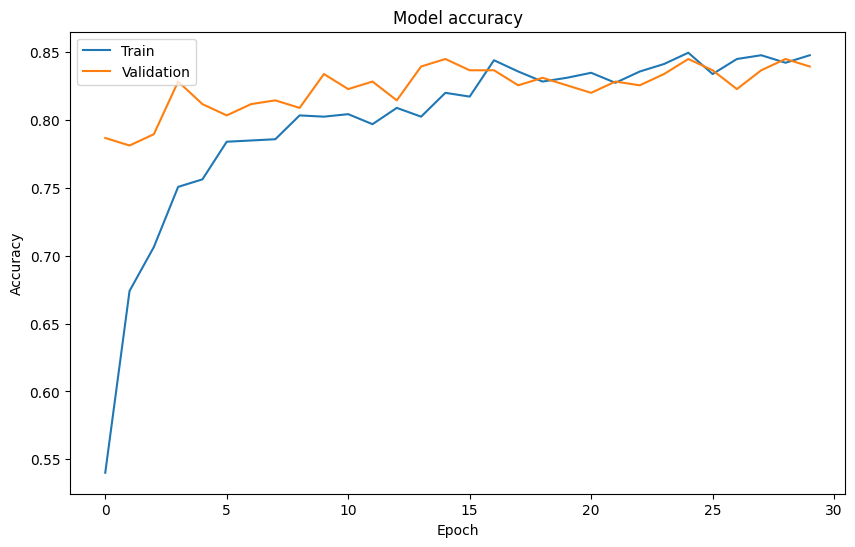

In [27]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

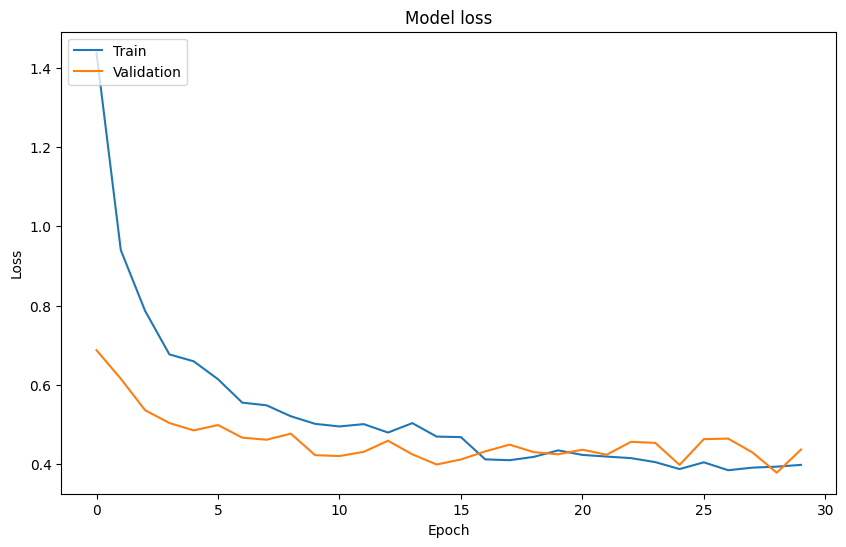

In [28]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()